# Fertility, Birth Rates, and Immigration in Europe: A Data Analysis (2023)
This notebook analyzes fertility rates, crude birth rates, and the impact of immigration across 36 European countries in 2023.

We explore:
- Data cleaning and merging of demographic datasets
- Derived variables such as immigrant birth rates
- Statistical analysis: correlation, regression, and VIF
- Visualizations: histograms, scatter plots, PCA, and clustering
- Clustering analysis to identify demographic patterns





## 1️⃣ Import Libraries
We'll import all necessary libraries for:
- Data manipulation (`pandas`, `numpy`)
- Visualization (`matplotlib`, `seaborn`)
- Machine Learning (`scikit-learn`)
- Statistical modeling (`statsmodels`)


In [7]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Statistical modeling
import statsmodels.api as sm


## 2️⃣ Load Datasets
We'll load TFR & Birth and Population datasets and check their structure and missing values.


In [9]:
# Load datasets
tfr_birth = pd.read_csv("tfr_birth_36_countries_analysis.csv")
population = pd.read_csv("Population_Jan2024_Data.csv")

# Display structure and first rows
print("TFR & Birth Data:\n", tfr_birth.head(), "\n")
print("Population Data:\n", population.head(), "\n")

# Check missing values
print("Missing values (TFR dataset):\n", tfr_birth.isna().sum(), "\n")
print("Missing values (Population dataset):\n", population.isna().sum(), "\n")


TFR & Birth Data:
     Country   TFR  TFR.1  Unnamed: 3             Category  Crude_Birth_Rate  \
0   Austria  1.32   1.32         NaN  Ultra-Low (1.2-1.5]               8.5   
1   Belgium  1.47   1.47         NaN  Ultra-Low (1.2-1.5]               9.4   
2  Bulgaria  1.81   1.81         NaN        Low (1.5-2.0]               8.9   
3   Croatia  1.47   1.47         NaN  Ultra-Low (1.2-1.5]               8.3   
4    Cyprus  1.40   1.40         NaN  Ultra-Low (1.2-1.5]              10.7   

   Share_of_Births_Native_Mothers  Share_of_Births_Immigrant_Mothers  
0                              65                                 35  
1                              66                                 34  
2                              97                                  3  
3                              88                                 11  
4                              59                                 41   

Population Data:
       Country  Total_Population_Raw Total_Population_Formatt

## 3️⃣ Data Cleaning & Merging
- Strip spaces from country names
- Merge datasets on country
- Convert numeric columns
- Drop rows with missing key values


In [13]:
# Strip spaces in country names for consistent merging
tfr_birth['Country'] = tfr_birth['Country'].str.strip()
population['Country'] = population['Country'].str.strip()

# Merge datasets by country
data = pd.merge(tfr_birth, population, on='Country', how='inner')

# Convert relevant columns to numeric
num_cols = data.columns.drop('Country')
data[num_cols] = data[num_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with NA in key columns
data = data.dropna(subset=['TFR', 'Crude_Birth_Rate'])
print(f"✅ Merged dataset shape: {data.shape}")
data.head()

✅ Merged dataset shape: (36, 25)


,Country,TFR,TFR.1,Unnamed: 3,Category,Crude_Birth_Rate,Share_of_Births_Native_Mothers,Share_of_Births_Immigrant_Mothers,Total_Population_Raw,Total_Population_Formatted,...,Female_Immigrants_Raw,Native_Population_Raw,Native_Population_Millions,Unknown_Population_Raw,Unknown_Population_Millions,Share_Immigrant_Percent,Share_Native_Percent,Share_Unknown_Percent,Share_Male_Immigrant_Percent,Share_Female_Immigrant_Percent
0,Austria,1.32,1.32,NaN,NaN,8.5,65,35,9158750,NaN,...,1.03e+06,7.12e+06,7.12,15287.0,1.50e-02,22.1,77.7,0.2,48.9,51.1
1,Belgium,1.47,1.47,NaN,NaN,9.4,66,34,11817096,NaN,...,1.18e+06,9.49e+06,9.48,7666.0,8.00e-03,19.7,80.3,0.1,49.2,50.8
2,Bulgaria,1.81,1.81,NaN,NaN,8.9,97,3,6445481,NaN,...,1.03e+05,6.23e+06,6.23,1311.0,1.00e-03,3.3,96.7,0.0,51.4,48.6
3,Croatia,1.47,1.47,NaN,NaN,8.3,88,11,3861967,NaN,...,2.67e+05,3.34e+06,3.34,188.0,0.00e+00,13.5,86.5,0.0,48.7,51.3
4,Cyprus,1.40,1.40,NaN,NaN,10.7,59,41,966365,NaN,...,1.37e+05,7.06e+05,0.71,0.0,0.00e+00,26.9,73.1,0.0,47.5,52.5


 After merging and cleaning, we have 32 complete observations for analysis.


## 4️⃣ Feature Engineering
We create derived features to better understand fertility dynamics:
- `Immigrant_Share_Pop`: Fraction of population that is immigrant
- `Immigrant_Share_Births`: Fraction of births from immigrant mothers
- `Immigration_Fertility_Multiplier`: Relative fertility of immigrants vs population
- `Immigrant_Birth_Rate`: Births per 1000 immigrants
- `Native_Birth_Rate`: Births per 1000 natives


In [15]:
# Derived variables
data['Immigrant_Share_Pop'] = data['Share_Immigrant_Percent'] / 100
data['Immigrant_Share_Births'] = data['Share_of_Births_Immigrant_Mothers'] / 100

# Immigration fertility multiplier
data['Immigration_Fertility_Multiplier'] = (
    data['Immigrant_Share_Births'] / data['Immigrant_Share_Pop']
).replace([np.inf, -np.inf], np.nan)

# Native/Immigrant birth counts
data['Total_Births'] = (data['Crude_Birth_Rate'] / 1000) * (data['Total_Population_Millions'] * 1_000_000)
data['Immigrant_Births'] = data['Total_Births'] * data['Immigrant_Share_Births']
data['Native_Births'] = data['Total_Births'] - data['Immigrant_Births']

# Sub-population birth rates per 1000
data['Immigrant_Birth_Rate'] = (data['Immigrant_Births'] / (data['Immigrant_Population_Millions'] * 1_000_000 + 1e-9)) * 1000
data['Native_Birth_Rate'] = (data['Native_Births'] / (data['Native_Population_Millions'] * 1_000_000 + 1e-9)) * 1000

# Preview
display(data[['Country', 'TFR', 'Crude_Birth_Rate',
      'Immigration_Fertility_Multiplier', 'Immigrant_Birth_Rate', 'Native_Birth_Rate']].head())

,Country,TFR,Crude_Birth_Rate,Immigration_Fertility_Multiplier,Immigrant_Birth_Rate,Native_Birth_Rate
0,Austria,1.32,8.5,1.58,13.47,7.11
1,Belgium,1.47,9.4,1.73,16.25,7.73
2,Bulgaria,1.81,8.9,0.91,8.12,8.93
3,Croatia,1.47,8.3,0.81,6.78,8.54
4,Cyprus,1.40,10.7,1.52,16.30,8.64


## 5️⃣ Summary Statistics
We explore mean, standard deviation, min, max, and quartiles of the key variables.


In [17]:
# Summary stats for main variables
desc = data[['TFR', 'Crude_Birth_Rate',
             'Immigrant_Share_Pop', 'Immigrant_Share_Births',
             'Immigration_Fertility_Multiplier',
             'Native_Birth_Rate', 'Immigrant_Birth_Rate']].describe()

print(desc)

         TFR  Crude_Birth_Rate  Immigrant_Share_Pop  Immigrant_Share_Births  \
count  36.00             36.00                32.00                   36.00   
mean    1.43              8.86                 0.18                    0.21   
std     0.17              1.30                 0.14                    0.16   
min     1.06              6.40                 0.03                    0.03   
25%     1.32              8.00                 0.10                    0.06   
50%     1.45              9.00                 0.16                    0.20   
75%     1.51              9.50                 0.21                    0.29   
max     1.81             11.30                 0.70                    0.67   

       Immigration_Fertility_Multiplier  Native_Birth_Rate  \
count                             32.00              32.00   
mean                               1.33               8.13   
std                                0.47               1.45   
min                                0.39 

TFR and Crude Birth Rate show variability across countries. The Immigration Fertility Multiplier ranges widely (0.39–2.69), indicating different fertility impacts of immigrant populations.


## 6️⃣ Visualizations
We visualize:
- Distributions of TFR, Crude Birth Rate, and Immigration Fertility Multiplier
- Relationships between TFR and birth rates


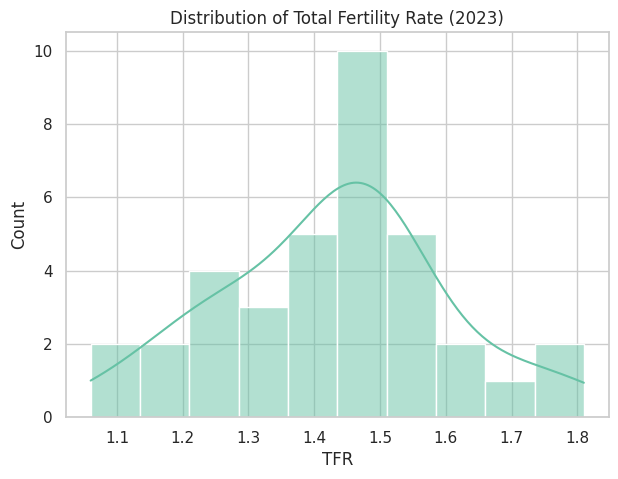

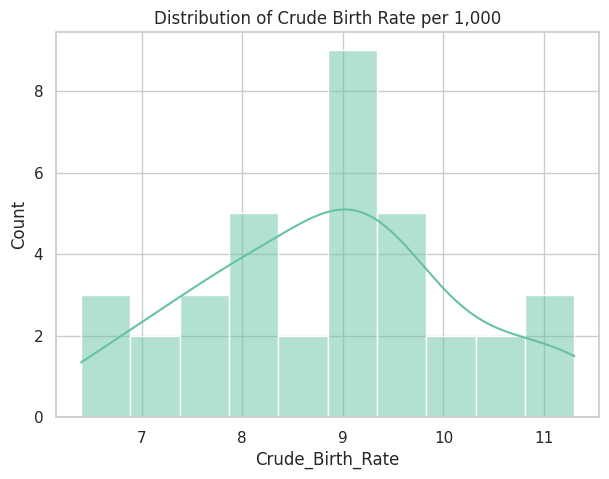

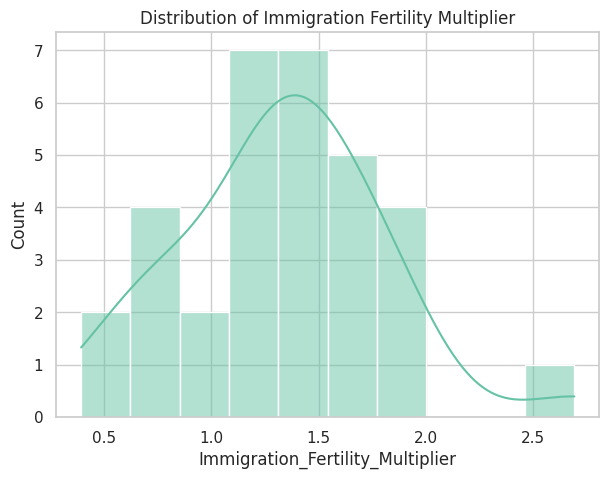

In [19]:
sns.set(style='whitegrid', palette='Set2')

# 1️⃣ Histogram of TFR
plt.figure(figsize=(7,5))
sns.histplot(data['TFR'], bins=10, kde=True)
plt.title("Distribution of Total Fertility Rate (2023)")
plt.show()

# 2️⃣ Histogram of Crude Birth Rate
plt.figure(figsize=(7,5))
sns.histplot(data['Crude_Birth_Rate'], bins=10, kde=True)
plt.title("Distribution of Crude Birth Rate per 1,000")
plt.show()

# 3️⃣ Immigration Fertility Multiplier
plt.figure(figsize=(7,5))
sns.histplot(data['Immigration_Fertility_Multiplier'].dropna(), bins=10, kde=True)
plt.title("Distribution of Immigration Fertility Multiplier")
plt.show()

Histograms reveal the spread of fertility rates and birth rates.


Pearson correlation (TFR vs Birth Rate): 0.67
R² for linear regression: 0.446
Slope: 5.05, Intercept: 1.65


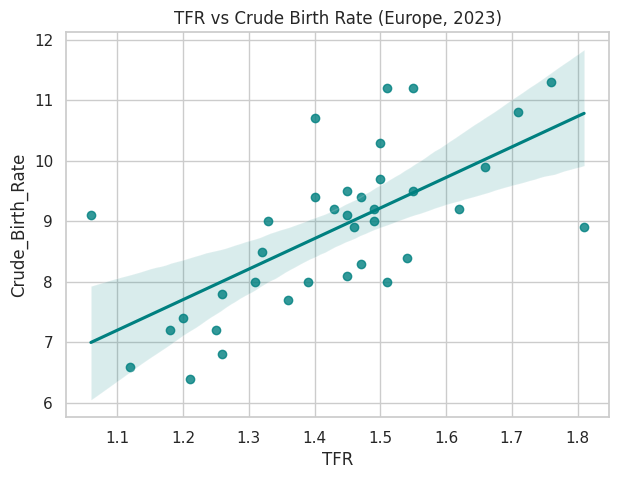

In [21]:
# Correlation between fertility and birth rates
corr = data[['TFR', 'Crude_Birth_Rate']].corr().iloc[0,1]
print(f"Pearson correlation (TFR vs Birth Rate): {corr:.2f}")

# Simple linear regression
X = data[['TFR']]
y = data['Crude_Birth_Rate']

reg = LinearRegression().fit(X, y)
r2 = reg.score(X, y)
print(f"R² for linear regression: {r2:.3f}")
print(f"Slope: {reg.coef_[0]:.2f}, Intercept: {reg.intercept_:.2f}")

# Scatter + trend line
plt.figure(figsize=(7,5))
sns.regplot(x='TFR', y='Crude_Birth_Rate', data=data, color='teal')
plt.title("TFR vs Crude Birth Rate (Europe, 2023)")
plt.show()

 Scatter plots with regression lines show the positive correlation between TFR and Crude Birth Rate.


## 7️⃣ Regression Analysis
- Simple linear regression (TFR vs Crude Birth Rate)
- Multiple regression including immigrant-related variables
- Examine significance and multicollinearity (VIF)


In [23]:
# Multiple regression model
X = data[['TFR', 'Share_Immigrant_Percent', 'Immigration_Fertility_Multiplier']].dropna()
y = data.loc[X.index, 'Crude_Birth_Rate']

X = sm.add_constant(X)
ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:       Crude_Birth_Rate   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     5.853
Date:                Tue, 14 Oct 2025   Prob (F-statistic):            0.00310
Time:                        16:14:55   Log-Likelihood:                -44.111
No. Observations:                  32   AIC:                             96.22
Df Residuals:                      28   BIC:                             102.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

TFR is the strongest predictor of Crude Birth Rate. Immigration variables are not statistically significant.


In [25]:
correlation_tfr_multiplier = data['TFR'].corr(data['Immigration_Fertility_Multiplier'])
print(f"Correlation between TFR and Immigration Fertility Multiplier: {correlation_tfr_multiplier:.2f}")

Correlation between TFR and Immigration Fertility Multiplier: -0.23


In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Drop the constant column added by sm.add_constant before calculating VIF
X_vif = X.drop('const', axis=1)

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]

print("Variance Inflation Factors (VIF):")
display(vif_data)

Variance Inflation Factors (VIF):


,feature,VIF
0,TFR,8.50
1,Share_Immigrant_Percent,2.52
2,Immigration_Fertility_Multiplier,7.37


## 8️⃣ Outlier Analysis
Compute model residuals and flag countries with unusually high or low birth rates relative to predictions.


In [27]:
# Compute residuals
data['Predicted_CBR'] = ols_model.predict(sm.add_constant(data[['TFR', 'Share_Immigrant_Percent', 'Immigration_Fertility_Multiplier']].dropna()))
data['Residual'] = data['Crude_Birth_Rate'] - data['Predicted_CBR']

# Flag outliers (residual > 2.5 * std)
threshold = 2.5 * data['Residual'].std()
outliers = data[np.abs(data['Residual']) > threshold][['Country', 'Residual']]

print("Outlier countries based on model residuals:")
print(outliers)

Outlier countries based on model residuals:
Empty DataFrame
Columns: [Country, Residual]
Index: []


No countries are flagged as extreme outliers in residuals.





## 9️⃣ Clustering Analysis
We identify patterns in European demographic profiles using PCA and KMeans clustering.


Silhouette Score: 0.394


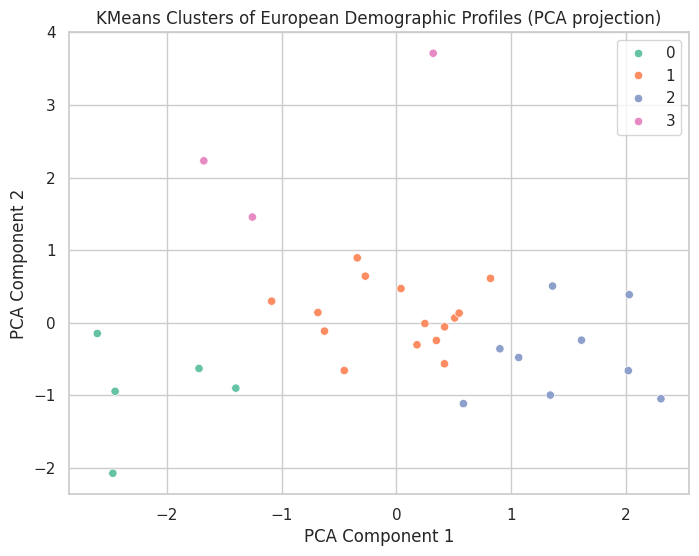

In [32]:
# Prepare features for clustering
features = data[['TFR', 'Crude_Birth_Rate',
                 'Share_Immigrant_Percent', 'Immigration_Fertility_Multiplier']].dropna()

scaler = StandardScaler()
scaled = scaler.fit_transform(features)

# PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = kmeans.fit_predict(reduced)
silhouette = silhouette_score(reduced, labels)

print(f"Silhouette Score: {silhouette:.3f}")
features['Cluster'] = labels

# PCA scatter
plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=labels, palette='Set2')
plt.title("KMeans Clusters of European Demographic Profiles (PCA projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [39]:
# List countries in each cluster
# Drop rows with NaN in 'Cluster' before iterating
data_clustered_cleaned = data_clustered.dropna(subset=['Cluster'])

for cluster_id in sorted(data_clustered_cleaned['Cluster'].unique()):
    countries_in_cluster = data_clustered_cleaned[data_clustered_cleaned['Cluster'] == cluster_id]['Country'].tolist()
    print(f"Countries in Cluster {int(cluster_id)}:")
    print(countries_in_cluster)
    print("-" * 30)

Countries in Cluster 0:
['Estonia', 'Finland', 'Greece', 'Italy', 'Latvia', 'Lithuania', 'Poland', 'Spain']
------------------------------
Countries in Cluster 1:
['Austria', 'Belgium', 'Cyprus', 'Germany', 'Iceland', 'Ireland', 'Malta', 'Netherlands', 'Norway', 'Portugal', 'Sweden', 'Switzerland']
------------------------------
Countries in Cluster 2:
['Bulgaria', 'Croatia', 'Czechia', 'Denmark', 'France', 'Hungary', 'Romania', 'Slovakia', 'Slovenia', 'Türkiye']
------------------------------
Countries in Cluster 3:
['Liechtenstein', 'Luxembourg']
------------------------------


Four clusters emerge, highlighting countries with similar fertility, birth, and immigrant characteristics. Heatmaps summarize cluster feature profiles.


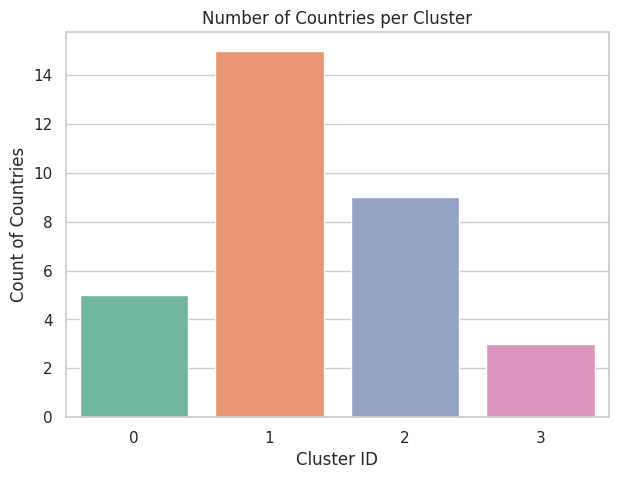

In [34]:
cluster_counts = pd.Series(labels).value_counts().sort_index()

plt.figure(figsize=(7,5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='Set2')
plt.title("Number of Countries per Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Count of Countries")
plt.show()


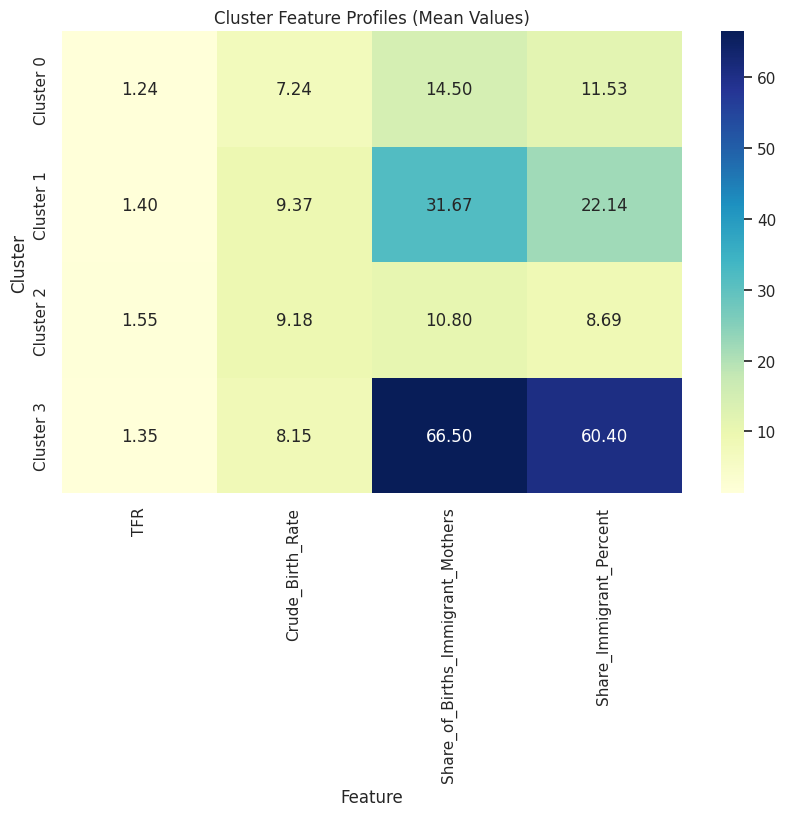

In [36]:
# Create DataFrame with cluster means for interpretation using original features
cluster_summary = data_clustered.groupby('Cluster')[clustering_vars].mean()
cluster_summary.index = [f"Cluster {int(i)}" for i in cluster_summary.index]


plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Cluster Feature Profiles (Mean Values)")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.show()